In [1]:
import numpy as np
import pandas as pd

from spatialkfold.blocks import spatial_blocks
from sklearn.model_selection import GroupKFold
import geopandas as gpd

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
import contextily as ctx
import matplotlib.pyplot as plt
import seaborn as sns

import os,sys,glob

In [2]:
data = pd.read_csv("../results/CSVs/Train_clean.csv",parse_dates=["date"])

# Spatial Sampling

In [3]:
dfsp = data.copy()
dfsp = dfsp[["date","stn_ID","lat","lng"]]

In [4]:
dfsp.head()

,date,stn_ID,lat,lng
0,2016-01-01,454909257,45.496780,9.257515
1,2016-01-01,451709488,45.171919,9.488997
2,2016-01-01,452808988,45.281956,8.988563
3,2016-01-01,455409205,45.542665,9.205603
4,2016-01-01,455408847,45.548517,8.847322


In [5]:
gdf = gpd.GeoDataFrame(dfsp,geometry=gpd.points_from_xy(dfsp.lng, dfsp.lat, crs=4326))

In [6]:
gdf.head()

,date,stn_ID,lat,lng,geometry
0,2016-01-01,454909257,45.496780,9.257515,POINT (9.25751 45.49678)
1,2016-01-01,451709488,45.171919,9.488997,POINT (9.48900 45.17192)
2,2016-01-01,452808988,45.281956,8.988563,POINT (8.98856 45.28196)
3,2016-01-01,455409205,45.542665,9.205603,POINT (9.20560 45.54266)
4,2016-01-01,455408847,45.548517,8.847322,POINT (8.84732 45.54852)


In [7]:
blocks = spatial_blocks(gdf=gdf, width=0.05, height=0.05, 
                                  method='continuous', orientation='tb-lr' ,
                                  nfolds=10, random_state= 175)

In [8]:
# sample the data with the prepared blocks 
stn_block = gpd.overlay (gdf, blocks)

In [9]:
# Get the 'tab20' colormap
cols_tab = cm.get_cmap('tab10', 10)
# Generate a list of colors from the colormap
cols = [cols_tab(i) for i in range(10)]
# create a color ramp
color_ramp = ListedColormap(cols)

ConnectionError: HTTPSConnectionPool(host='a.tile.openstreetmap.fr', port=443): Max retries exceeded with url: /hot/10/536/365.png (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7efb10a776d0>: Failed to establish a new connection: [Errno 101] Network is unreachable'))

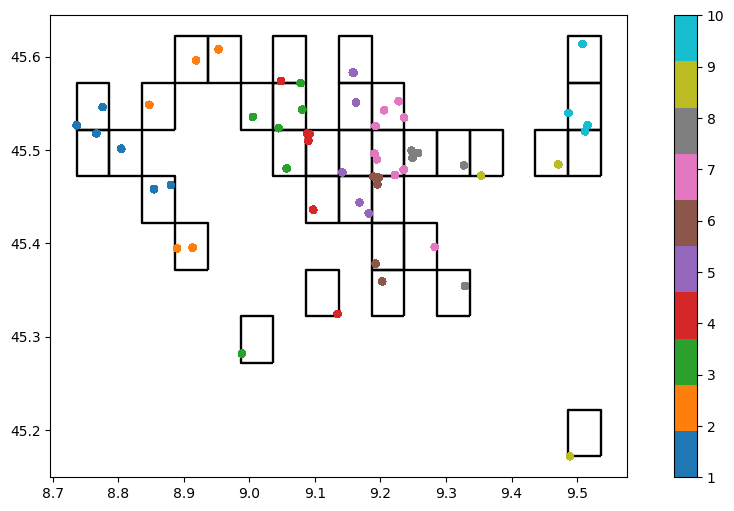

In [11]:
fig, ax = plt.subplots(1,1 , figsize=(12, 6))

blocks.plot(facecolor="none",edgecolor='black', ax = ax ,lw=1.7)
stn_block.plot(column = 'folds', cmap = color_ramp,legend = True, ax = ax, markersize = 20, marker="o")

ctx.add_basemap(ax,
               crs=stn_block.crs.to_string(),
               source=ctx.providers.OpenStreetMap.HOT
              )
plt.show()

# Temporal Sampling

In [115]:
dftmp = data.copy()

In [13]:
gkf = GroupKFold(n_splits=5)

In [14]:
for i,j in gkf.split(dftmp.iloc[:,1:5], dftmp["pm25"], groups=dftmp['date']):
    train = dftmp.iloc[i,:]
    test = dftmp.iloc[j,:]

In [15]:
dftmp.shape,data.shape

((93466, 59), (93466, 59))

In [16]:
all_samples = dftmp[dftmp.date <= "31.1.2016"].set_index("date")
train_sample = train[train.date <= "31.1.2016"].set_index("date")
test_sample = test[test.date <= "31.1.2016"].set_index("date")

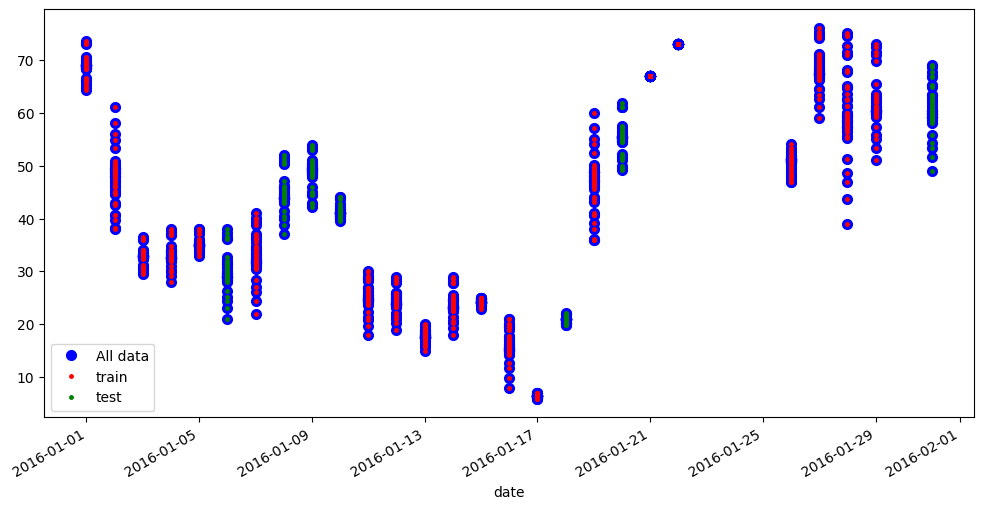

In [17]:
fig, ax = plt.subplots(1,1 , figsize=(12, 6))
all_samples["pm25"].plot(style='.',ax=ax,markersize=14,color="blue")
train_sample["pm25"].plot(style='.',ax=ax,markersize=5,color="red")
test_sample["pm25"].plot(style='.',ax=ax,markersize=5,color="green")
plt.legend(["All data", "train","test"])
plt.show()

In [229]:
def preq_bls(data, n_folds):
    """divide data into blocks. Incrementally slide over blocks.
    A test block is added to the training block.
    """
    train_list = []
    test_list = []
    if not isinstance(data["date"].dtype, np.datetime64):
        # Convert the 'Date' column to datetime type
        data["date"] = pd.to_datetime(data["date"])

    indices = data["date"].unique()
    block_size = math.ceil(len(indices) / n_folds)
    block_starts = np.arange(0, len(data) + 1, block_size)
    for i in range(n_folds-1):
        train_start = block_starts[0]
        train_end = block_starts[i+1]
        test_start = block_starts[i+1]
        test_end = block_starts[i+2]
        train_idx = indices[train_start:train_end]
        test_idx = indices[test_start:test_end]
        train_list.append(train_idx)
        test_list.append(test_idx)
        # print(f"Fold: {i} \ntrain: {train_idx} \nTest: {test_idx}")
    return train_list, test_list

In [230]:
def plot_split(train_idx_list, test_idx_list,title):
    # Plot the folds
    fig, ax = plt.subplots()
    for i, (train_idx, test_idx) in enumerate(zip(train_idx_list, test_idx_list)):
        ax.scatter(train_idx, [i+1]*len(train_idx), color='blue', label='Train' , s=50)
        ax.scatter(test_idx, [i+1]*len(test_idx), color='red', label='Test', s=50)
    ax.set_xlabel('Index')
    ax.set_ylabel('Fold')
    ax.set_title(title)
    ax.legend(loc='best')
    plt.show()
    return

In [235]:
train_list, test_list = preq_bls(data, 5)

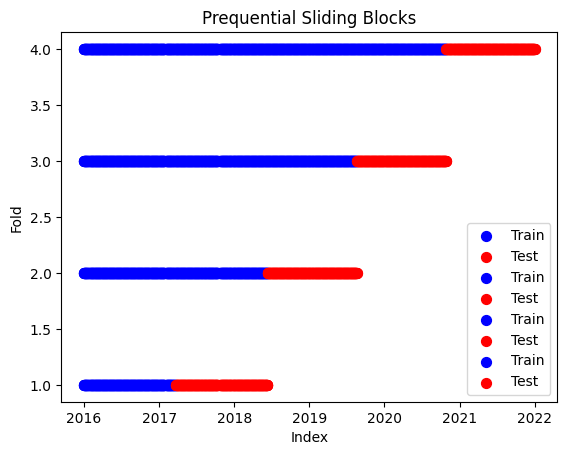

In [274]:
plot_split(train_list, test_list, "Prequential Sliding Blocks")